<a href="https://colab.research.google.com/github/d-portugal/chest_x_ray/blob/main/chest_xray_APA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Packages**

In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, sys
import zipfile          
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import splitfolders
import shutil

Importar dados

In [3]:
#Download do arquivo zip pelo google drive
!gdown 14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp

#Diretório do zip
chest_xray = "/content/chest_xray.zip"

#Diretório para o arquivo extraido
target_dir = "/content/sample_data/dataset"

#Extração
zfile = zipfile.ZipFile(chest_xray)
zfile.extractall(target_dir)

Downloading...
From: https://drive.google.com/uc?id=14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp
To: /content/chest_xray.zip
100% 1.15G/1.15G [00:05<00:00, 201MB/s]


Train Test Split

In [4]:
#Train test split, 20% dos dados serão usados para testar o modelo
treinamento_path = '/content/sample_data/dataset/chest_xray/treinamento'
splitfolders.ratio(treinamento_path, output="/content/sample_data/dataset/chest_xray", move = True,  seed=1, ratio=(.8, 0.2)) 

#Remover o folder que ficou vazio depois da divisão entre treino e teste
shutil.rmtree('/content/sample_data/dataset/chest_xray/treinamento')

#Renomear os folders
os.rename('/content/sample_data/dataset/chest_xray/validacao','/content/sample_data/dataset/chest_xray/valid')
os.rename('/content/sample_data/dataset/chest_xray/val','/content/sample_data/dataset/chest_xray/test')

Copying files: 5065 files [00:00, 16809.14 files/s]


Definições

In [5]:
#Caminhos das pastas de treino, teste e validação

train_path = '/content/sample_data/dataset/chest_xray/train'
test_path = '/content/sample_data/dataset/chest_xray/test'
valid_path = '/content/sample_data/dataset/chest_xray/valid'

#Tamanho das imagens

img_height = 128
img_width = 128

#Quantidade de imagens que será utilizada a cada iteração

batch_size = 1000 

#Quantidade de classes
num_classes = 3

#Reproducibilidade
def set_seed(seed=1):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

Carregar imagens

In [35]:
ds_train = image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

ds_test = image_dataset_from_directory(
    test_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

ds_valid = image_dataset_from_directory(
    valid_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

Found 4051 files belonging to 3 classes.
Found 1014 files belonging to 3 classes.
Found 166 files belonging to 3 classes.


---

Visualização das imagens

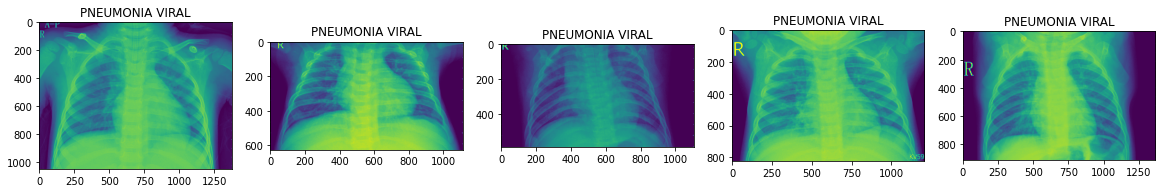

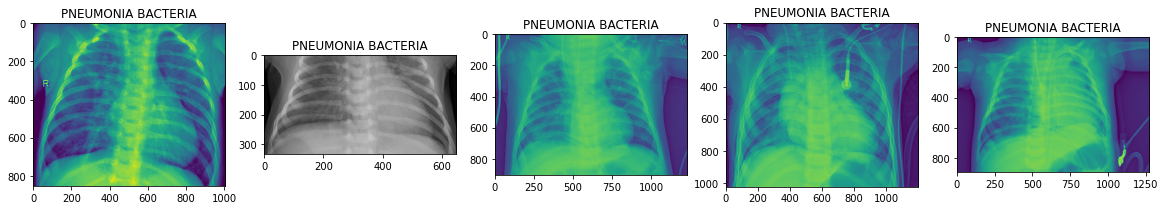

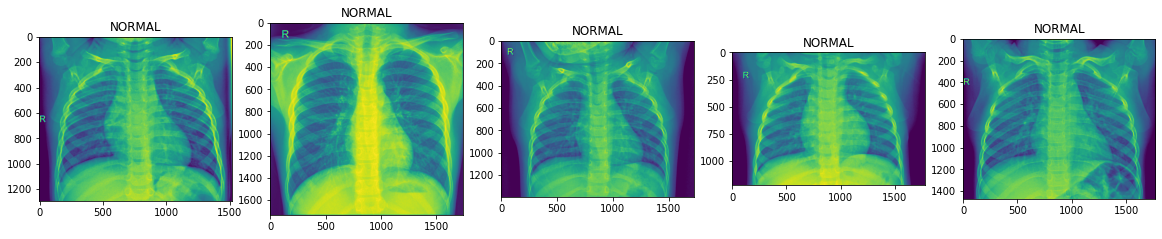

In [36]:
directory = os.listdir(train_path)
for each in directory:
    plt.figure(figsize = (20, 20))
    currentFolder = train_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img = mpimg.imread(fullpath)
        plt.subplot(2, 5, i+1)
        plt.title(each)
        plt.imshow(img)

---

Modelagem

1.   CNN

In [37]:
model = keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [38]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

2.   CNN + Data Augmentation

In [60]:
model_aug = keras.Sequential([
    preprocessing.RandomFlip(mode = 'horizontal'),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [61]:
model_aug.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

3.  CNN Transfer Learning  

In [12]:
pretrained_base = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

pretrained_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model_transf = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [14]:
model_transf.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

----

Treinamento

In [15]:
tf.get_logger().setLevel('ERROR') #Suprimir warnings to Tensorflow devido ao looping utilizado no Data Augmentation

1. CNN

In [39]:
history = model.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Epoch 1/50
5/5 [==============================] - 8s 480ms/step - loss: 34.7732 - accuracy: 0.4209 - val_loss: 3.8267 - val_accuracy: 0.2584
Epoch 2/50
5/5 [==============================] - 7s 431ms/step - loss: 2.6963 - accuracy: 0.3809 - val_loss: 1.1215 - val_accuracy: 0.4911
Epoch 3/50
5/5 [==============================] - 7s 431ms/step - loss: 1.0673 - accuracy: 0.4811 - val_loss: 0.9482 - val_accuracy: 0.5789
Epoch 4/50
5/5 [==============================] - 7s 430ms/step - loss: 0.9761 - accuracy: 0.5152 - val_loss: 0.9278 - val_accuracy: 0.6479
Epoch 5/50
5/5 [==============================] - 7s 438ms/step - loss: 0.9336 - accuracy: 0.6073 - val_loss: 1.0827 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 7s 431ms/step - loss: 0.9689 - accuracy: 0.5739 - val_loss: 0.8680 - val_accuracy: 0.5710
Epoch 7/50
5/5 [==============================] - 7s 434ms/step - loss: 0.8515 - accuracy: 0.6033 - val_loss: 0.8349 - val_accuracy: 0.6519
Epoch 8/50
5/5 [===

In [42]:
history_frame = pd.DataFrame(history.history)
print(history_frame)

         loss  accuracy  val_loss  val_accuracy
0   34.773216  0.420884  3.826650      0.258383
1    2.696261  0.380894  1.121490      0.491124
2    1.067268  0.481116  0.948179      0.578895
3    0.976056  0.515181  0.927770      0.647929
4    0.933627  0.607257  1.082717      0.500000
5    0.968922  0.573932  0.867984      0.571006
6    0.851529  0.603308  0.834900      0.651874
7    0.830647  0.649716  0.830832      0.634122
8    0.783068  0.663293  0.731329      0.712032
9    0.723978  0.708961  0.691371      0.714004
10   0.676481  0.727722  0.636602      0.738659
11   0.619402  0.755863  0.609020      0.745562
12   0.594585  0.755369  0.556097      0.761341
13   0.557020  0.768699  0.564345      0.754438
14   0.543143  0.771661  0.535717      0.778107
15   0.511841  0.786966  0.527252      0.774162
16   0.494321  0.788200  0.526815      0.770217
17   0.476530  0.792397  0.509361      0.774162
18   0.459171  0.806961  0.529574      0.779093
19   0.474938  0.792644  0.518251      0

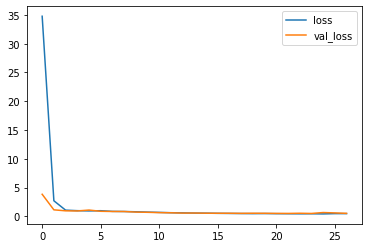

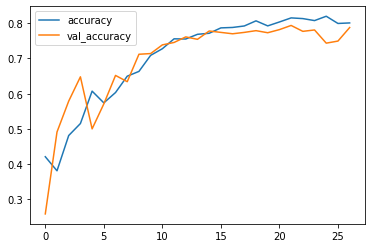

In [43]:
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

2.   CNN + Data Augmentation

In [62]:
history_aug = model_aug.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Epoch 1/50
5/5 [==============================] - 10s 748ms/step - loss: 20.2113 - accuracy: 0.4308 - val_loss: 4.9944 - val_accuracy: 0.2505
Epoch 2/50
5/5 [==============================] - 8s 704ms/step - loss: 2.5772 - accuracy: 0.3713 - val_loss: 1.3421 - val_accuracy: 0.2584
Epoch 3/50
5/5 [==============================] - 8s 712ms/step - loss: 1.1816 - accuracy: 0.4325 - val_loss: 1.0549 - val_accuracy: 0.5306
Epoch 4/50
5/5 [==============================] - 8s 709ms/step - loss: 1.0343 - accuracy: 0.4974 - val_loss: 1.0232 - val_accuracy: 0.4862
Epoch 5/50
5/5 [==============================] - 8s 707ms/step - loss: 1.0018 - accuracy: 0.4883 - val_loss: 0.9861 - val_accuracy: 0.4921
Epoch 6/50
5/5 [==============================] - 8s 702ms/step - loss: 0.9755 - accuracy: 0.5251 - val_loss: 0.9536 - val_accuracy: 0.5769
Epoch 7/50
5/5 [==============================] - 8s 700ms/step - loss: 0.9416 - accuracy: 0.5648 - val_loss: 0.9233 - val_accuracy: 0.5809
Epoch 8/50
5/5 [==

In [51]:
history_aug_frame = pd.DataFrame(history_aug.history)
print(history_aug_frame)

         loss  accuracy  val_loss  val_accuracy
0   27.317104  0.327820  5.529464      0.250493
1    2.567295  0.421871  1.140222      0.258383
2    1.058865  0.443841  1.020087      0.491124
3    0.983448  0.540360  0.916049      0.625247
4    0.905093  0.608245  1.064847      0.494083
5    0.918470  0.570476  0.824903      0.621302
6    0.828981  0.649963  0.788010      0.651874
7    0.777969  0.677117  0.760382      0.690335
8    0.770737  0.664527  0.734092      0.703156
9    0.730038  0.696124  0.657355      0.719921
10   0.664581  0.722291  0.630607      0.722880
11   0.625826  0.732412  0.597649      0.744576
12   0.619303  0.738089  0.639598      0.726824
13   0.597538  0.745248  0.569100      0.753452
14   0.591425  0.747470  0.623415      0.718935
15   0.595826  0.755616  0.642169      0.729783
16   0.612464  0.732165  0.595671      0.750493


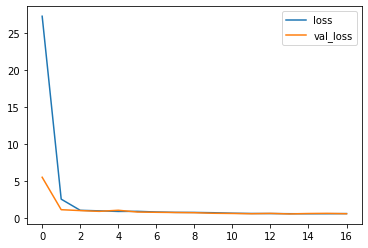

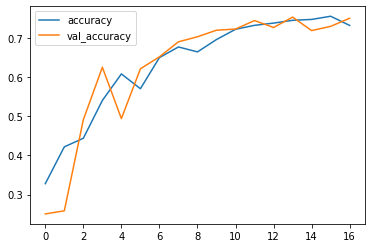

In [52]:
history_aug_frame.loc[:, ['loss', 'val_loss']].plot()
history_aug_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

3.   CNN Transfer Learning

In [27]:
history_transfer = model_transf.fit(
    ds_train,
    validation_data = ds_test,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=3)
)

Epoch 1/50
5/5 [==============================] - 12s 807ms/step - loss: 44.2247 - accuracy: 0.4315 - val_loss: 23.3810 - val_accuracy: 0.3836
Epoch 2/50
5/5 [==============================] - 8s 602ms/step - loss: 12.9682 - accuracy: 0.5241 - val_loss: 3.5568 - val_accuracy: 0.7002
Epoch 3/50
5/5 [==============================] - 8s 605ms/step - loss: 3.4203 - accuracy: 0.6401 - val_loss: 2.9143 - val_accuracy: 0.5769
Epoch 4/50
5/5 [==============================] - 8s 610ms/step - loss: 1.9826 - accuracy: 0.6663 - val_loss: 1.6112 - val_accuracy: 0.7150
Epoch 5/50
5/5 [==============================] - 8s 604ms/step - loss: 1.3471 - accuracy: 0.7144 - val_loss: 0.8953 - val_accuracy: 0.7209
Epoch 6/50
5/5 [==============================] - 8s 605ms/step - loss: 0.8229 - accuracy: 0.6951 - val_loss: 0.8406 - val_accuracy: 0.6548
Epoch 7/50
5/5 [==============================] - 8s 596ms/step - loss: 0.8193 - accuracy: 0.6492 - val_loss: 0.7946 - val_accuracy: 0.6736
Epoch 8/50
5/5 [

In [28]:
history_transfer = pd.DataFrame(history_transfer.history)
print(history_aug_frame)

         loss  accuracy   val_loss  val_accuracy
0   27.053179  0.375463  20.358006      0.250493
1    8.710805  0.276475   1.365781      0.333333
2    1.120291  0.461861   0.938353      0.551282
3    0.914265  0.573932   0.871545      0.575937
4    0.844274  0.599358   0.796915      0.657791
5    0.764953  0.671192   0.849643      0.602564
6    0.768229  0.660084   0.782439      0.559172
7    0.715143  0.661071   0.659985      0.686391
8    0.635417  0.723525   0.667057      0.702170
9    0.609990  0.734140   0.586640      0.732742
10   0.613423  0.731918   0.606037      0.727811
11   0.596544  0.738089   0.567052      0.757396
12   0.565338  0.758825   0.558318      0.762327
13   0.548461  0.772402   0.583174      0.733728
14   0.544697  0.764996   0.522366      0.775148
15   0.526605  0.768946   0.539663      0.769231
16   0.532732  0.778326   0.511439      0.785996
17   0.515883  0.785485   0.521195      0.762327
18   0.490545  0.786472   0.511299      0.774162
19   0.508031  0.776

<Figure size 432x288 with 0 Axes>

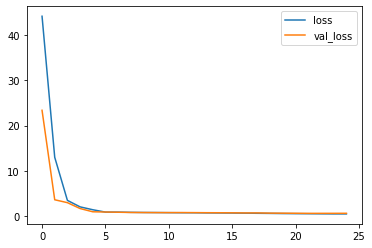

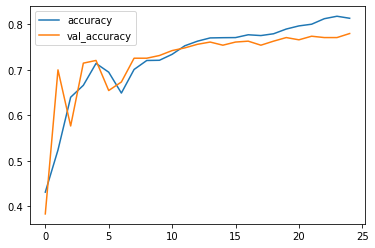

In [65]:
history_transfer.loc[:, ['loss', 'val_loss']].plot()
history_transfer.loc[:, ['accuracy', 'val_accuracy']].plot();

Model Saves

In [30]:
model.save()
model_aug.save()
model_aug_transfer.save()

TypeError: ignored